In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc
import sklearn

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 5
FOLDS = [4,5]
PATH = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/' # Main path
DATA_PATH = PATH + 'dataset/' # Data folder
TRAIN_PATH = DATA_PATH + 'train_images/'# Training images folder
ENCODER_NAME = "resnet18"
PATCH_H = 512
PATCH_W = 512
ANGLE = 30
patch_size = 64
Lmax = 15
LR_MAX = 5e-6#1e-5
BS = 32
EPOCHS = 16

In [3]:
spinal = [
    'spinal_canal_stenosis_l1_l2',
    'spinal_canal_stenosis_l2_l3',
    'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5',
    'spinal_canal_stenosis_l5_s1'
]
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'
]
labels = {
    'Normal/Mild':0,
    'Moderate':1,
    'Severe':2,
    'UNK':-100
}

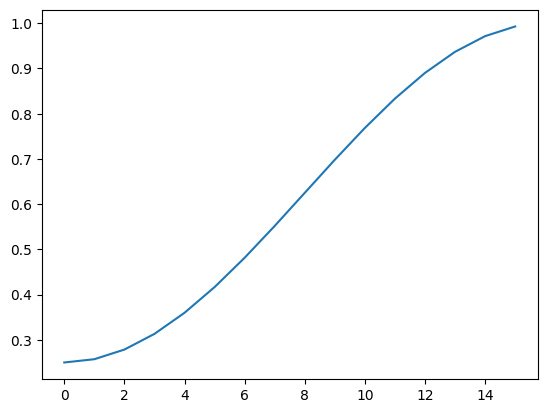

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# CosineAnnealingAlpha
def nt(nmin,nmax,tcur,tmax):
    return (nmax - .5*(nmax-nmin)*(1+np.cos(tcur*np.pi/tmax))).astype(np.float32)

plt.plot(nt(.25,1,np.arange(EPOCHS),EPOCHS))
plt.show()

# callback to update alpha during training
def cb(self):
    alpha = torch.as_tensor(nt(.25,1,learn.train_iter,EPOCHS*n_iter))
    learn.dls.train_ds.alpha = alpha
alpha_cb = Callback(before_batch=cb)

def augment_image(image):
#   Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-ANGLE, ANGLE))
    image = torchvision.transforms.functional.rotate(
        image,angle.item(),
#       interpolation=torchvision.transforms.InterpolationMode.BILINEAR
    )
    return image

In [5]:
train = pd.read_csv(DATA_PATH + 'train_split.csv')
train = train[['study_id','fold']+spinal][train[spinal].isna().sum(1) < len(spinal)].reset_index(drop=True)
train.tail()

,study_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
1969,4282019580,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1970,4283570761,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1971,4284048608,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1972,4287160193,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
1973,4290709089,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [6]:
train = train.fillna('UNK')
train[(train[spinal] == 'UNK').sum(1)>0].reset_index(drop=True).tail()

,study_id,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1


In [7]:
df_coor = pd.read_csv(DATA_PATH + 'train_label_coordinates.csv')
df_coor.tail()

,study_id,series_id,instance_number,condition,level,x,y
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333
48691,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L5/S1,211.813953,259.534884


In [8]:
S = df_coor[
    df_coor['condition'] == 'Spinal Canal Stenosis'
].sort_values([
    'study_id',
    'series_id',
    'level'
]).reset_index(drop=True)
S.tail()

,study_id,series_id,instance_number,condition,level,x,y
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249


In [9]:
S['x_mean_fraction'] = S['x']/S.groupby(['study_id','series_id'])['x'].mean().loc[[(study_id,series_id) for study_id,series_id in S[['study_id','series_id']].values]].values
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [10]:
S = S[S['x_mean_fraction'] > .8]
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [11]:
S['instance_number'] = S['instance_number'] - 1
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,8,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,8,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,8,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,8,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,8,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [12]:
coordinates = {}
for study_id,df in S.groupby('study_id'):
    coordinates[study_id] = {}
for (study_id,series_id),df in tqdm(S.groupby(['study_id','series_id'])):
    coordinates[study_id][series_id] = {
                'L1/L2':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                    'L2/L3':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L3/L4':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L4/L5':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L5/S1':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                }
    }
    
    for i in range(len(df)):
        row = df.iloc[i]
        coordinates[row['study_id']][row['series_id']][row['level']]['x'] = row['x']
        coordinates[row['study_id']][row['series_id']][row['level']]['y'] = row['y']
        coordinates[row['study_id']][row['series_id']][row['level']]['instance_number'] = row['instance_number']

100%|██████████| 1974/1974 [00:01<00:00, 1622.47it/s]


In [13]:
S =  S[[
    'study_id',
    'series_id'
]].groupby([
    'study_id',
    'series_id'
]).count().reset_index()
S.tail()

,study_id,series_id
1969,4282019580,1547999333
1970,4283570761,453728183
1971,4284048608,3767301072
1972,4287160193,1507070277
1973,4290709089,3274612423


In [14]:
v = np.zeros((len(S),15))
for i in tqdm(range(len(S))):
    row = S.iloc[i]
    k = 0
    for level in coordinates[row['study_id']][row['series_id']]:
        v[i,k:k+3] = list(coordinates[row['study_id']][row['series_id']][level].values())
        k += 3

  0%|          | 0/1974 [00:00<?, ?it/s]100%|██████████| 1974/1974 [00:00<00:00, 9337.22it/s]


In [15]:
S[[
    'x_L1L2',
    'y_L1L2',
    'i_L1L2',
    'x_L2L3',
    'y_L2L3',
    'i_L2L3',
    'x_L3L4',
    'y_L3L4',
    'i_L3L4',
    'x_L4L5',
    'y_L4L5',
    'i_L4L5',
    'x_L5S1',
    'y_L5S1',
    'i_L5S1'
]] = v
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,i_L3L4,x_L4L5,y_L4L5,i_L4L5,x_L5S1,y_L5S1,i_L5S1
1969,4282019580,1547999333,217.588235,104.823529,10.0,202.305085,151.864407,10.0,196.411765,193.764706,10.0,203.470588,241.058824,10.0,214.058824,274.235294,10.0
1970,4283570761,453728183,252.096578,148.066797,8.0,239.788300,209.608186,8.0,232.427696,265.899924,8.0,235.546307,315.797706,8.0,254.013013,364.807609,8.0
1971,4284048608,3767301072,290.154631,203.001570,9.0,276.591052,269.915228,9.0,272.974097,335.020408,9.0,280.208006,391.083203,11.0,295.580063,443.529042,11.0
1972,4287160193,1507070277,391.235190,235.644570,7.0,369.435472,321.805360,7.0,373.587800,391.356841,7.0,397.463681,456.755994,7.0,427.568054,516.964739,7.0
1973,4290709089,3274612423,181.668947,88.864569,8.0,174.227086,125.198358,8.0,174.227086,160.656635,8.0,182.544460,191.299590,8.0,194.363885,218.878249,8.0


In [16]:
S = S.merge(train,left_on='study_id',right_on='study_id')
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,...,i_L4L5,x_L5S1,y_L5S1,i_L5S1,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1
1969,4282019580,1547999333,217.588235,104.823529,10.0,202.305085,151.864407,10.0,196.411765,193.764706,...,10.0,214.058824,274.235294,10.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1970,4283570761,453728183,252.096578,148.066797,8.0,239.788300,209.608186,8.0,232.427696,265.899924,...,8.0,254.013013,364.807609,8.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1971,4284048608,3767301072,290.154631,203.001570,9.0,276.591052,269.915228,9.0,272.974097,335.020408,...,11.0,295.580063,443.529042,11.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1972,4287160193,1507070277,391.235190,235.644570,7.0,369.435472,321.805360,7.0,373.587800,391.356841,...,7.0,427.568054,516.964739,7.0,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild
1973,4290709089,3274612423,181.668947,88.864569,8.0,174.227086,125.198358,8.0,174.227086,160.656635,...,8.0,194.363885,218.878249,8.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [17]:
mask = S[[
    'x_L1L2',
    'x_L2L3',
    'x_L3L4',
    'x_L4L5',
    'x_L5S1'
]].isna().values
mask += S[[
    'y_L1L2',
    'y_L2L3',
    'y_L3L4',
    'y_L4L5',
    'y_L5S1'
]].isna().values
mask += S[[
    'i_L1L2',
    'i_L2L3',
    'i_L3L4',
    'i_L4L5',
    'i_L5S1'
]].isna().values
mask = mask > 0
mask[-5:]
v = S[spinal].values
v[mask] = 'UNK'
S[spinal] = v

In [18]:
S['flip'] = False
fS = S.copy()
fS['flip'] = True
S = pd.concat([S,fS]).reset_index(drop=True)
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,...,x_L5S1,y_L5S1,i_L5S1,fold,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,flip
3943,4282019580,1547999333,217.588235,104.823529,10.0,202.305085,151.864407,10.0,196.411765,193.764706,...,214.058824,274.235294,10.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True
3944,4283570761,453728183,252.096578,148.066797,8.0,239.788300,209.608186,8.0,232.427696,265.899924,...,254.013013,364.807609,8.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True
3945,4284048608,3767301072,290.154631,203.001570,9.0,276.591052,269.915228,9.0,272.974097,335.020408,...,295.580063,443.529042,11.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,True
3946,4287160193,1507070277,391.235190,235.644570,7.0,369.435472,321.805360,7.0,373.587800,391.356841,...,427.568054,516.964739,7.0,5.0,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,True
3947,4290709089,3274612423,181.668947,88.864569,8.0,174.227086,125.198358,8.0,174.227086,160.656635,...,194.363885,218.878249,8.0,5.0,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,True


In [19]:
S.groupby('fold').count()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,...,i_L4L5,x_L5S1,y_L5S1,i_L5S1,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,flip
fold,,,,,,,,,,,,,,,,,,,,,
1.0,790,790,764,764,764,782,782,782,790,790,...,788,782,782,782,790,790,790,790,790,790
2.0,790,790,748,748,748,768,768,768,790,790,...,788,790,790,790,790,790,790,790,790,790
3.0,790,790,762,762,762,764,764,764,786,786,...,788,786,786,786,790,790,790,790,790,790
4.0,788,788,764,764,764,776,776,776,786,786,...,786,782,782,782,788,788,788,788,788,788
5.0,790,790,760,760,760,774,774,774,790,790,...,790,788,788,788,790,790,790,790,790,790


In [20]:
class Sagittal_T2_Spinal_Dataset(Dataset):
    def __init__(self, df, VALID=False, P=patch_size):
        self.data = df
        self.VALID = VALID
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        
        
        sample = TRAIN_PATH + str(row['study_id']) + '/'+str(row['series_id'])

        images = [x.replace('\\','/') for x in glob.glob(sample+'/*.dcm')]
        images.sort(reverse=False, key=lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        instance_numbers = row[[
            'i_L1L2',
            'i_L2L3',
            'i_L3L4',
            'i_L4L5',
            'i_L5S1'
        ]].values

        label = torch.as_tensor([labels[x] for x in row[spinal]]).to(device)

        image = torch.stack([
            torch.as_tensor(pydicom.dcmread(x).pixel_array.astype(np.float32)) for x in images
        ]).float().to(device)
        image = image/image.max()
        D,H,W = image.shape

        c = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        missing = c.isnan().sum(1) > 0
        c[missing] = torch.as_tensor([H/2,W/2])

        label[missing] = - 100

        if H > W:
            d = W
            h = (H - d)//2
            image = image[:,h:h+d]
            c[:,1] -= h
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            image = image[:,:,w:w+d]
            c[:,0] -= w
            W = H

        image = self.resize(image)
        image = nn.functional.pad(image,[self.P]*4,'reflect')
        c[:,1] = c[:,1]*PATCH_H/H + self.P
        c[:,0] = c[:,0]*PATCH_W/W + self.P
        c = c.long()
        if not self.VALID: c += torch.normal(0,5,(5,2)).long()

        crops = torch.stack([
            image[
                :,
                xy[1]-self.P:xy[1]+self.P,
                xy[0]-self.P:xy[0]+self.P
            ] for xy in c
        ])

        image = torch.zeros(5,Lmax,2*self.P,2*self.P).to(device)
        slices_mask = torch.ones(5,Lmax).bool().to(device)
        for i in range(5):
            if ~missing[i]:
                instance_number = instance_numbers[i].astype(int)
                start = max([0,instance_number - Lmax//2])
                end = min([D,start + Lmax])
                crop = crops[i,start:end]

                if row.flip:
                    image[i,:len(crop)] = crop.flip(0)
                else:
                    image[i,:len(crop)] = crop
                slices_mask[i,:len(crop)] = False

                if not self.VALID:
                    image[i] = augment_image(image[i].reshape(-1,2*self.P,2*self.P)).reshape(Lmax,2*self.P,2*self.P)
            
        image = image[:,:,self.P//2:self.P//2+self.P,self.P//2:self.P//2+self.P]

        return [image,slices_mask],label

In [21]:
ds = Sagittal_T2_Spinal_Dataset(S)

tensor([0, 0, 1, 0, 0], device='cuda:0')


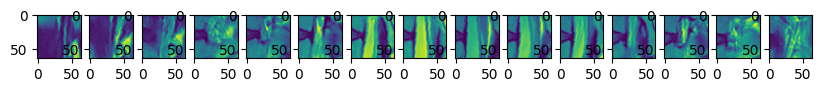

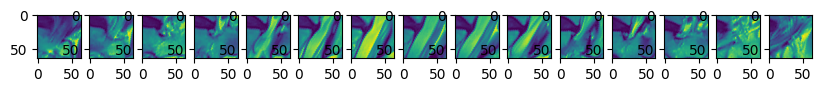

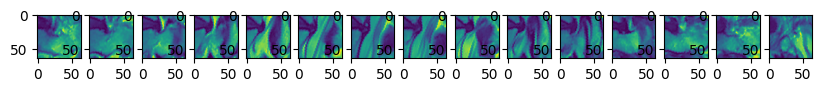

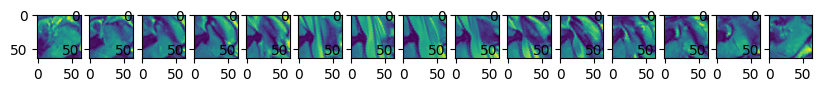

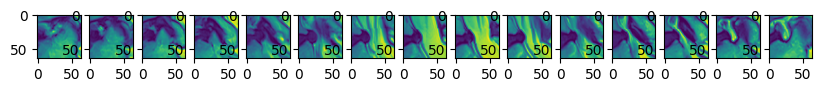

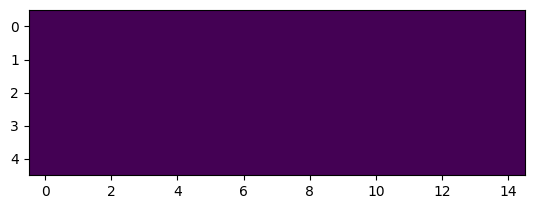

In [22]:
[sample,mask],label = ds.__getitem__(np.random.randint(len(ds)))
print(label)
for k in range(5):
    fig, axes = plt.subplots(1,Lmax, figsize=(10,2))
    for i in range(2):
        for j in range(Lmax):
            axes[j].imshow(sample.cpu()[k,j])
    plt.show()

plt.imshow(mask.cpu().view(-1,Lmax))

In [23]:
del ds
gc.collect()

34385

In [24]:
class Sagittal_T2_spine_Discriminator(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        CNN = torchvision.models.resnet18(weights='DEFAULT')
        W = nn.Parameter(CNN.conv1.weight.sum(1, keepdim=True))
        CNN.conv1 = nn.Conv2d(1, patch_size, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        CNN.conv1.weight = W
        CNN.fc = nn.Identity()
        self.emb = CNN.to(device)
        self.proj_out = nn.Linear(dim,2).to(device)
    
    def forward(self, x):        
        x = self.emb(x.view(-1,1,patch_size,patch_size))
        x = self.proj_out(x.view(-1,512))
        return x

In [25]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class Sagittal_T2_Spinal_ViT(nn.Module):
    def __init__(
            self,
            ENCODER,
            dim=512,
            depth=24,
            head_size=64
        ):
        super().__init__()
        self.ENCODER = ENCODER
        self.slices_enc = SinusoidalPosEmb(dim)(torch.arange(Lmax, device=device).unsqueeze(0))
        self.slices_enc = nn.Parameter(self.slices_enc)
        pos_enc = SinusoidalPosEmb(dim)(torch.arange(5, device=device).unsqueeze(0))
        self.pos_enc = nn.Parameter(pos_enc)
        self.slices_transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True, device=device), depth)
        self.proj_out = nn.Linear(dim,3).to(device)
    
    def forward(self, x):
        x,slices_mask = x
        slices_mask = slices_mask.view(-1,Lmax)
        mask = slices_mask.sum(-1) < Lmax
        
        x = self.ENCODER(x.view(-1,1,patch_size,patch_size))

        x = x.view(-1,Lmax,512)
        x = x + self.slices_enc
        x[mask] = self.slices_transformer(x[mask],src_key_padding_mask=slices_mask[mask])

        x[slices_mask] = 0
        d = (~slices_mask).sum(1).unsqueeze(-1).tile(1,512)
        x = x.sum(1)
        x[d > 0] = x[d > 0]/d[d > 0]

        level_mask = (slices_mask.sum(1) == Lmax).view(-1,5)
        x = x.view(-1,5,512) + self.pos_enc
        x = self.transformer(x,src_key_padding_mask=level_mask)
        x = self.proj_out(x.view(-1,512)).view(-1,5,3)
        return x

In [26]:
def myLoss(preds,target):
    target = target.view(-1)
    preds = preds.view(-1,3)
    
    return nn.CrossEntropyLoss(weight=torch.as_tensor([1.,2.,4.]).to(device))(preds,target)

epoch,train_loss,valid_loss,time
0,0.732079,0.575000,12:39
1,0.574035,0.345816,12:40
2,0.478511,0.316075,12:02
3,0.430179,0.303258,11:30
4,0.436835,0.418426,11:26
5,0.394055,0.315322,11:13
6,0.379945,0.312369,11:10
7,0.380446,0.333714,11:10
8,0.352238,0.282738,11:11
9,0.334740,0.291416,11:12


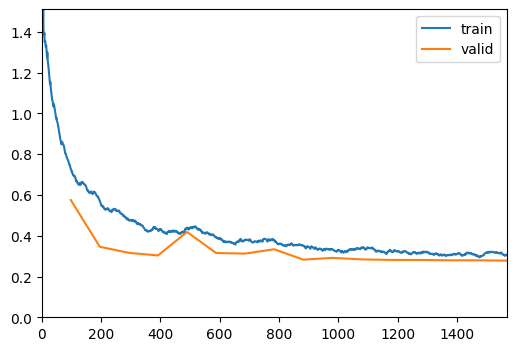

epoch,train_loss,valid_loss,time
0,0.769392,0.645293,11:11
1,0.571276,0.423692,11:40
2,0.454518,0.342082,12:07
3,0.421902,0.332166,12:18
4,0.393885,0.317729,11:20
5,0.367514,0.334296,11:25
6,0.355679,0.319901,11:48
7,0.360160,0.300120,11:10
8,0.334430,0.304180,11:12
9,0.320053,0.285834,11:14


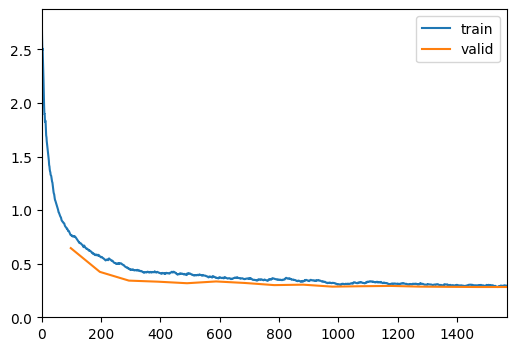

In [27]:
for f in FOLDS:
    seed_everything(SEED)
    model = Sagittal_T2_Spinal_ViT(
        torch.load(DATA_PATH + 'Sagittal_T2/discriminator/Sagittal_T2_spine_discriminator_'+str(f)).emb
    )
    df = S
    tdf = df[df.fold != f]
    vdf = df[df.fold == f]
    tds = Sagittal_T2_Spinal_Dataset(tdf)
    vds = Sagittal_T2_Spinal_Dataset(vdf,VALID=True)
    tdl = torch.utils.data.DataLoader(tds, batch_size=BS, shuffle=True, drop_last=True)
    vdl = torch.utils.data.DataLoader(vds, batch_size=BS, shuffle=False)
    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        loss_func=myLoss,
        cbs=[
            ShowGraphCallback(),
            GradientClip(3.0),
            alpha_cb
        ]
    )
    learn.fit_one_cycle(EPOCHS, lr_max=LR_MAX, wd=0.05, pct_start=0.02)
    torch.save(model,'Sagittal_T2_Spinal_ViT_'+str(f))
    del model,df,tdf,vdf,tds,vds,tdl,vdl,dls,learn
    gc.collect()

In [28]:
FOLDS = [
    '''0	0.908724	0.633825	12:41
1	0.542367	0.627722	12:53
2	0.481850	0.481803	11:25
3	0.423859	0.318504	11:13
4	0.389764	0.335094	11:18
5	0.381459	0.319343	11:20
6	0.369244	0.373869	11:17
7	0.338741	0.319158	11:17
8	0.327234	0.322730	11:07
9	0.325960	0.336394	11:17
10	0.319744	0.302709	11:15
11	0.321403	0.320284	11:24
12	0.299962	0.302910	11:15
13	0.303122	0.318872	11:26
14	0.292123	0.305572	11:25
15	0.295646	0.306218	11:27''',
    '''0	0.834889	0.626539	11:56
1	0.559498	0.518421	11:19
2	0.462401	0.395586	11:30
3	0.431726	0.364882	11:20
4	0.390481	0.343762	11:18
5	0.381275	0.321904	11:17
6	0.365477	0.336417	11:33
7	0.372566	0.325591	11:34
8	0.326688	0.302057	12:02
9	0.318840	0.314251	11:17
10	0.311919	0.297093	13:36
11	0.320316	0.300823	11:32
12	0.307305	0.298338	11:06
13	0.308204	0.298642	11:12
14	0.300773	0.294550	11:30
15	0.302716	0.295606	11:12''',
    '''0	0.849269	0.930417	11:11
1	0.541680	0.391493	11:23
2	0.458766	0.356661	11:29
3	0.425333	0.330684	11:15
4	0.400492	0.343798	11:12
5	0.381700	0.317394	11:36
6	0.374329	0.338669	12:36
7	0.346137	0.305142	12:16
8	0.329711	0.314581	11:47
9	0.321498	0.315245	12:45
10	0.333052	0.302263	12:39
11	0.306373	0.313393	11:55
12	0.302495	0.309797	11:59
13	0.299533	0.303616	11:43
14	0.295559	0.304309	12:23
15	0.299785	0.301494	11:47''',
    '''0	0.732079	0.575000	12:39
1	0.574035	0.345816	12:40
2	0.478511	0.316075	12:02
3	0.430179	0.303258	11:30
4	0.436835	0.418426	11:26
5	0.394055	0.315322	11:13
6	0.379945	0.312369	11:10
7	0.380446	0.333714	11:10
8	0.352238	0.282738	11:11
9	0.334740	0.291416	11:12
10	0.338533	0.284008	11:09
11	0.330591	0.281311	11:06
12	0.315402	0.281208	11:09
13	0.305365	0.279470	11:10
14	0.302912	0.279434	12:34
15	0.305688	0.277819	12:40''',
    '''0	0.769392	0.645293	11:11
1	0.571276	0.423692	11:40
2	0.454518	0.342082	12:07
3	0.421902	0.332166	12:18
4	0.393885	0.317729	11:20
5	0.367514	0.334296	11:25
6	0.355679	0.319901	11:48
7	0.360160	0.300120	11:10
8	0.334430	0.304180	11:12
9	0.320053	0.285834	11:14
10	0.328051	0.289729	11:10
11	0.308249	0.292546	11:10
12	0.306878	0.286116	11:09
13	0.300543	0.283985	11:06
14	0.297565	0.282372	11:07
15	0.294830	0.282471	11:11'''
]